In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


<font size="6"> KMeans Initiation (by Stefanie) </font>

In [2]:
# Just for inspecting (and not forgetting about some potentially useful features from) the whole joined dataset
df_jointdata = pd.read_csv('joint_data.csv')
df_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,viewpoint,Müggeleck,0.000138
1,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,bench,NaN,0.000551
2,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,bench,NaN,0.000122
3,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,bench,NaN,0.000110
4,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,bench,NaN,0.000319


In [3]:
# Loading extracted poicount data and making it easy to work with
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)
df_poicount.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Writing the easier to work with df in a new csv file
df_poicount.to_csv(r'poicount.csv', index=False)

In [5]:
# Calculating the percentage of the feature "tree"
print('Trees make out by far the largest amount in our data.', df_poicount['tree'].sum()/df_poicount.iloc[:, 3:].sum().sum()*100, "% of our points of interest is trees.")

Trees make out by far the largest amount in our data. 79.83184053389533 % of our points of interest is trees.


<AxesSubplot:>

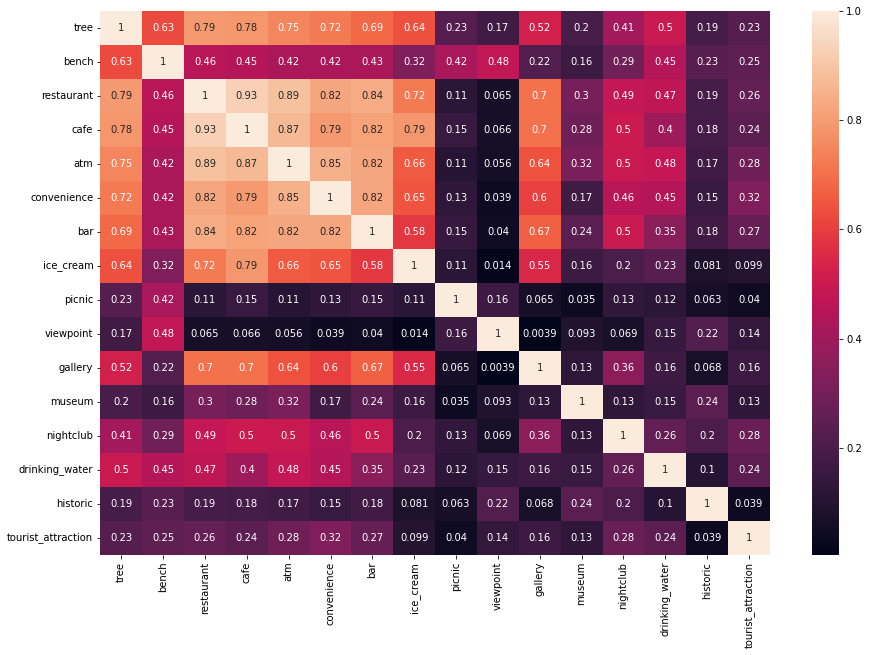

In [7]:
# Getting correlations for all the points of interest (poi)
correlations = df_poicount.iloc[:, 3:].corr()
f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(correlations,annot=True)

Over the thumb summary: 

We can see that restaurants, cafes, convenience shops, atms, bars, ice cream shops, galleries, and trees often come along (meaning being on the same route) with each other. It can be suspected that these togeter will form a cluster. (Sometimes, there's also nightclubs and drinking water on these routes.)

Viewpoints and picnic tables don't correlate with most of the other features, not even with each other, which is surprising. But sometimes they come along with benches, which make sense. 

Trees, surprisingly, don't seem to join the nature routes that often, but tend to be on those routes with shops and cafes. 

Tourist attractions and historic sides don't show a clear correlation and seem to be scattered among the other categories (we only have small amounts of those in our dataset though). 

Nightclubs seem to go best with bars, cafes and atms, but no clear correlation here.

In [15]:
# Reading poicount data in as numpy arrays
poicount = np.genfromtxt('poicount.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

print("Since this notebook is suppused to log a process, we for now go with the unstandardised data and see what happens:")

Since this notebook is suppused to log a process, we for now go with the unstandardised data and see what happens:


Elbow method for finding the best k for kMeans

In [16]:
# Increasing k by 1 with every step and store the SSE in a list
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 500}

# Writing the SSE values for each k into a list
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    sse.append(kmeans.inertia_)
sse

[43656285.76744186,
 15578526.253332185,
 7194192.91662691,
 5607922.786596571,
 2735574.8748075585,
 1970453.7813721495,
 1703122.2214129784,
 1570020.9677248397,
 1515145.6020301513,
 993752.8941334155]

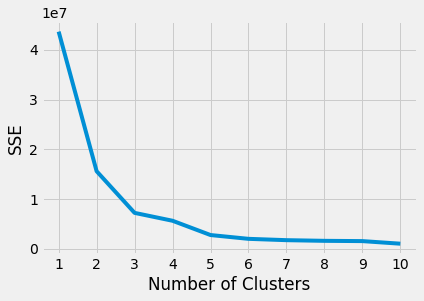

In [17]:
# Graphically finding the "elbow", where the SSE and the number of clusters are in reasonable trade-off to each other
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2 or 3 clusters can be found. Looking at the ancles of the ellbow, it seems, that two of them are relatively close to each other.

In [18]:
# Using the Python package "kneed" to identify the elbow point programmatically
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

There seems to be 3 clusters. Let's also implement the silhouette coefficient.

In [19]:
# Making a List for the silhouette coefficients for each k, starting at 2
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    score = silhouette_score(poicount, kmeans.labels_)
    silhouette_coefficients.append(score)

silhouette_coefficients

[0.8134777043053864,
 0.7282809013676836,
 0.723097498219662,
 0.6585220748121681,
 0.6452131359680884,
 0.5861195928222211,
 0.5728411054952953,
 0.5478955595700152,
 0.5477451394498852]

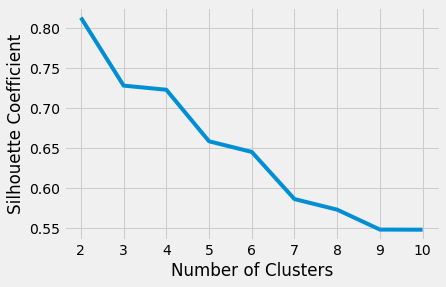

In [20]:
# Plotting the average silhouette scores for each k
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This would speak for there being 2 clusters. By experimenting a bit with the data (not shown here) we found out, that when we'd reduce it to two clusters, then the biggest cluster would "eat" the second biggest cluster, which is a gross loss in information, especially since the biggest cluster is the biggest by far. So, we'll go with 3 clusters here.

Implementing KMeans

In [21]:
# Initialising the KMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=3, n_init=50, max_iter=500)

In [22]:
# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poicount)
label = kmeans.labels_ # getting lables for later mapping these to our dataframe

In [23]:
# Looking at the lowest SSE value
kmeans.inertia_

7194236.550377581

That high number is to be expected, because we have only 430 samples lost in 16 dimensions.

In [24]:
# Looking at the locations of the centroids
kmeans.cluster_centers_

array([[4.21650000e+02, 5.22250000e+01, 1.50375000e+01, 8.66250000e+00,
        3.48750000e+00, 3.18750000e+00, 2.81250000e+00, 1.26250000e+00,
        5.62500000e-01, 6.50000000e-01, 6.62500000e-01, 5.37500000e-01,
        5.25000000e-01, 4.25000000e-01, 2.25000000e-01, 1.75000000e-01],
       [4.53843844e+01, 1.37927928e+01, 3.06006006e+00, 1.63063063e+00,
        6.27627628e-01, 3.87387387e-01, 4.98498498e-01, 1.80180180e-01,
        3.54354354e-01, 2.79279279e-01, 1.29129129e-01, 1.83183183e-01,
        1.02102102e-01, 8.10810811e-02, 7.20720721e-02, 6.00600601e-02],
       [1.40500000e+03, 1.14705882e+02, 4.71176471e+01, 2.90588235e+01,
        1.28235294e+01, 9.47058824e+00, 8.88235294e+00, 2.94117647e+00,
        1.64705882e+00, 1.17647059e+00, 2.35294118e+00, 1.00000000e+00,
        1.76470588e+00, 1.58823529e+00, 4.11764706e-01, 3.52941176e-01]])

Looks like three distinct centroids, however when I ran this bevore, there were two quite similar ones (at eyesight quite close to each other) which lead me to believe that it might be only two "real" clusters.

In [25]:
# Number of iterations required to converge
print(kmeans.n_iter_, 'iterations')

11 iterations


That's surprisingsly fast (however before, I had had only 2 even). I haven't come to grips yet what this would tell us about the data.

In [26]:
# Cluster assignments
kmeans.labels_[:5] #looking at the first 5

array([1, 1, 1, 1, 1])

Probably all green routes with restaurats, cafes and so on (let's call it the "green city route") ... I'm sure that cluster is by far the largest.

In [27]:
# Checking how many times each lable appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 80, 1: 333, 2: 17}

There is one cluster that is much bigger than the others. It's probably the "green city route".

In [28]:
# Assigning the three cluster centres to each feature
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,421.650000,52.225000,15.037500,8.662500,3.487500,3.187500,2.812500,1.262500,0.562500,0.650000,0.662500,0.537500,0.525000,0.425000,0.225000,0.175000
1,45.384384,13.792793,3.060060,1.630631,0.627628,0.387387,0.498498,0.180180,0.354354,0.279279,0.129129,0.183183,0.102102,0.081081,0.072072,0.060060
2,1405.000000,114.705882,47.117647,29.058824,12.823529,9.470588,8.882353,2.941176,1.647059,1.176471,2.352941,1.000000,1.764706,1.588235,0.411765,0.352941


In [29]:
# Comment on the cluster dataframe (so it stays correct with each update)
max_value = max(dict(zip(unique, counts)).values())
max_keys = [k for k, v in dict(zip(unique, counts)).items() if v == max_value]
print('Obviously, "cluster', max_keys, '" stands out for its high procimity to "trees" and everything else!!!!')

Obviously, "cluster [1] " stands out for its high procimity to "trees" and everything else!!!!


Major revelation:
-----------------------------------------------------------------------------------------------------------------------------------------------------------------
KMeans had grouped the longer routes into one cluster. It wasn't intended to cluster on length of routes, but rather on the TYPES of features (points on interest along the routes. Solution: routes must be standardised before (axis = 0). With our data, it's of mayor importance to standardise, since the routes have a very huge variance in length:
-----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
# Displaying information on the variance in number of points of interest found for each route (consider the std)
df_poicount['poi'].describe()

count     430.000000
mean      211.869767
std       369.018893
min         1.000000
25%        14.000000
50%        62.000000
75%       256.250000
max      3171.000000
Name: poi, dtype: float64

In [61]:
# Standardising on axis 0 (rowise)
df_st = df_poicount.iloc[:, 3:].sub(df_poicount.mean(1), axis=0).div(df_poicount.std(1), axis=0) #standardising all the feature values on axis 0 
df_id_info = df_poicount.iloc[:, 0:3] # extracting the first three columns from the poicount df
df_poistand = pd.merge(df_id_info, df_st, how='outer', left_index=True, right_index=True) # joining on index
df_poistand.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,-0.229401,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418
1,2713522,8,2,-0.229417,-0.229414,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417
2,3503504,8,9,-0.229406,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418,-0.229418
3,3568200,8,18,-0.229397,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419,-0.229419
4,3573326,9,2,-0.229417,-0.229417,-0.229414,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417,-0.229417


In [60]:
# Writing the standardised df in a new csv file
df_poistand.to_csv(r'poistand.csv', index=False)

Now, we can restart the whole process.

In [71]:
# Reading poistand data in as numpy arrays
poistand = np.genfromtxt('poistand.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

"Elbow" method for finding the best k for kMeans

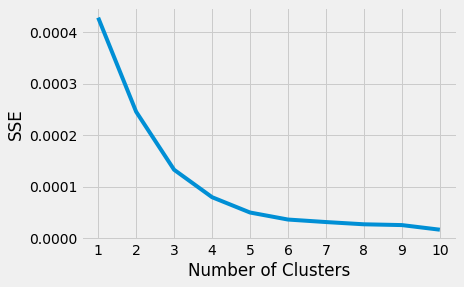

4


In [72]:
# Increasing k by 1 with every step and store the SSE in a list
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 500}

# Writing the SSE values for each k into a list
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poistand)
    sse.append(kmeans.inertia_)

# Graphically finding the "elbow", where the SSE and the number of clusters are in reasonable trade-off to each other
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Using the Python package "kneed" to identify the elbow point programmatically
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print(kl.elbow)

After standardisation, the "elbow" method now finds 4 clusters (maybe 3). Yeay.

Using silhouette coefficients for finding the best k

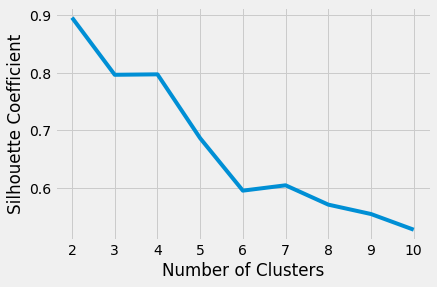

In [74]:
# Making a List for the silhouette coefficients for each k, starting at 2
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poistand)
    score = silhouette_score(poistand, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plotting the average silhouette scores for each k
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

It looks like we'd still best go with 2 clusters. At this point I wonder if I'm interpreting this graph the right way. I will look into it later.

Initialising kMeans with 4 clusters

In [91]:
# Initialising the kMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=4, n_init=50, max_iter=500)

# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poistand)
newlabel = kmeans.labels_ # getting lables for later mapping these to our dataframe

In [92]:
# Looking at the lowest SSE value
kmeans.inertia_

7.973540567490898e-05

Now in std units very small.

In [93]:
# Looking at the locations of the centroids
kmeans.cluster_centers_

array([[-0.22473609, -0.23232822, -0.23243599, -0.23260364, -0.23272339,
        -0.23278327, -0.23281919, -0.23284314, -0.23289104, -0.23289104,
        -0.23287906, -0.23286709, -0.23289104, -0.23289104, -0.23286709,
        -0.23289104],
       [-0.22931075, -0.22943894, -0.22946208, -0.229465  , -0.22946747,
        -0.22946774, -0.22946769, -0.22946843, -0.22946837, -0.22946843,
        -0.22946861, -0.22946856, -0.22946866, -0.22946872, -0.22946875,
        -0.22946878],
       [-0.22778601, -0.22965036, -0.22969107, -0.2297491 , -0.22978155,
        -0.22979646, -0.22979154, -0.2298047 , -0.22981175, -0.22981039,
        -0.22980981, -0.22980943, -0.22980779, -0.22981   , -0.22981304,
        -0.22981321],
       [-0.23052871, -0.2245066 , -0.23102811, -0.23099873, -0.23102811,
        -0.23102811, -0.23102811, -0.23102811, -0.23102811, -0.23093998,
        -0.23102811, -0.23102811, -0.23102811, -0.23099873, -0.23102811,
        -0.23102811]])

Difficult to read with the eyes.

In [94]:
# Number of iterations required to converge
print(kmeans.n_iter_, 'iterations')

16 iterations


In [95]:
# Cluster assignments
kmeans.labels_[:50] #looking at the first 5

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1])

Not enough variation. The hugest cluster will include most of the routes again.

In [96]:
# Checking how many times each lable appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 1, 1: 398, 2: 30, 3: 1}

Hugest cluster even huger than with not standardized data. The reason: it's not sensitive enough.

In [103]:
# Mapping our labels into our dataframe (each route gets a cluster label)
df_poicount_cluster = pd.concat([df_poicount, pd.DataFrame({'cluster':newlabel})], join='inner', axis=1)
df_poicount_cluster.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [100]:
# Writing the enhanced dataframe into a new csv file.
df_poicount_cluster.to_csv('clustered_routes.csv')

Let's try some dimensionality reduction accompanied with plotting using 3 clusters

In [101]:
# Principal Component Analysis
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_poistand)
pca_df = pd.DataFrame(data=principal_comp,columns=['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':newlabel})],axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-460507.851322,-498.846215,1
1,329473.145787,-430.462965,1
2,-460508.851148,-500.398996,1
3,-525204.851190,-503.509625,1
4,-530330.850696,-507.995575,1


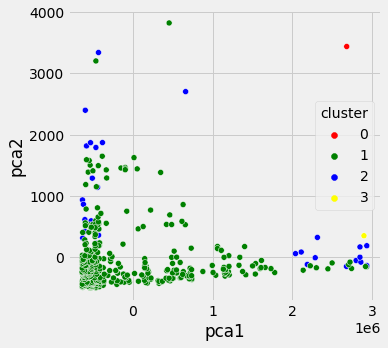

In [102]:
# Scatterplot of our clusters, reduced to two dimensions
plt.figure(figsize=(5,5))
ax= sns.scatterplot(x='pca1', y='pca2', hue='cluster',data=pca_df,palette=['red','green','blue','yellow'])
plt.show()

The clusters don't look spheric. There seems to be outliers, too. Next step would be to reduce the outliers and to make kMeans more sensitive.